# Linear Regression
Using various predictors to predict calories

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score


In [2]:
food = pd.read_excel("food.xlsx", sheet_name="food")

### Correlation

Looking at the corrolation matrix to figure out which variables to use.

In [3]:
cols = ['kilocalories', 'carbohydrate', 'protein', 'sugar', 'monosaturated_fat',
        'polysaturated_fat', 'saturated_fat', 'fiber', 'water', 'cholesterol', 'sodium']
food = food[cols].dropna()

corr = food.corr()
corr

,kilocalories,carbohydrate,protein,sugar,monosaturated_fat,polysaturated_fat,saturated_fat,fiber,water,cholesterol,sodium
kilocalories,1.000000,0.452811,0.156794,0.280782,0.699305,0.585958,0.612858,0.178744,-0.891119,0.042103,0.044848
carbohydrate,0.452811,1.000000,-0.251881,0.600980,-0.107136,-0.016261,-0.085187,0.431078,-0.756640,-0.195869,0.053244
protein,0.156794,-0.251881,1.000000,-0.229801,0.084963,-0.006125,0.063960,-0.034102,-0.160818,0.270320,0.014387
sugar,0.280782,0.600980,-0.229801,1.000000,-0.068148,-0.044828,0.026611,0.096485,-0.435410,-0.116053,-0.001113
monosaturated_fat,0.699305,-0.107136,0.084963,-0.068148,1.000000,0.597676,0.534592,-0.036299,-0.400847,0.084838,0.014827
polysaturated_fat,0.585958,-0.016261,-0.006125,-0.044828,0.597676,1.000000,0.277695,0.062173,-0.365784,0.006944,0.005833
saturated_fat,0.612858,-0.085187,0.063960,0.026611,0.534592,0.277695,1.000000,-0.076738,-0.350776,0.105390,0.005332
fiber,0.178744,0.431078,-0.034102,0.096485,-0.036299,0.062173,-0.076738,1.000000,-0.367935,-0.134047,-0.017714
water,-0.891119,-0.756640,-0.160818,-0.435410,-0.400847,-0.365784,-0.350776,-0.367935,1.000000,0.029871,-0.142799
cholesterol,0.042103,-0.195869,0.270320,-0.116053,0.084838,0.006944,0.105390,-0.134047,0.029871,1.000000,-0.010448


### VIF Calculations 
Finding if there is multicollinearity between variables

In [4]:

# add total fat column
food['total_fat'] = food['saturated_fat'] + food['polysaturated_fat'] + food['monosaturated_fat']

X = food[['total_fat', 'carbohydrate', 'water']]
X = sm.add_constant(X)  # Intercept term

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_list = []
for i in range(len(X.columns)):
    vif_value = variance_inflation_factor(X.values, i)
    vif_list.append(vif_value)

vif_data["VIF"] = vif_list
print(vif_data)

        feature        VIF
0         const  54.767016
1     total_fat   3.014071
2  carbohydrate   5.550504
3         water   6.990501


### Graphing the relationship

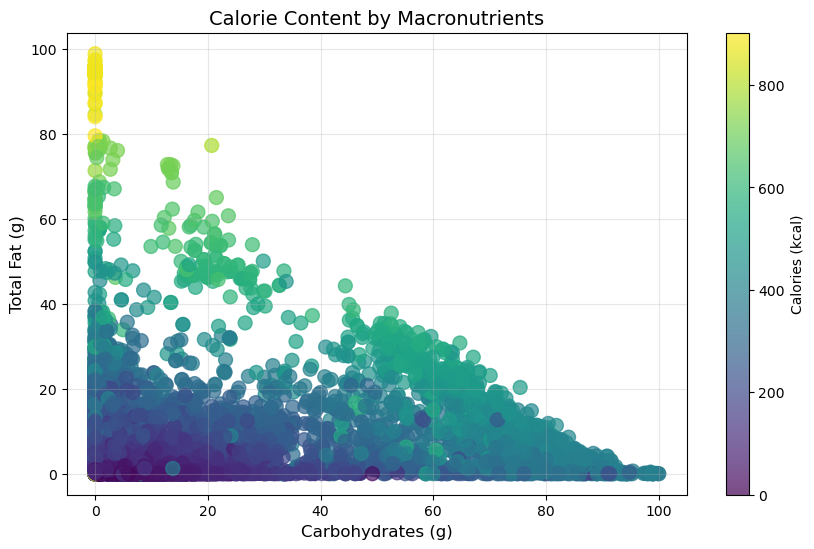

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(
    food['carbohydrate'],
    food['total_fat'],
    c=food['kilocalories'],
    cmap='viridis',
    s=100,
    alpha=0.7
)
plt.xlabel('Carbohydrates (g)', fontsize=12)
plt.ylabel('Total Fat (g)', fontsize=12)
cbar = plt.colorbar()
cbar.set_label('Calories (kcal)')
plt.title('Calorie Content by Macronutrients', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

### Linear Regression Model

I am going to use carbohydrates and total fat to predict kilocalories.

In [11]:


X = food[['carbohydrate', 'total_fat']]
y = food[['kilocalories']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"R² Score:{r2_score(y_test, y_pred):.4f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

R² Score:0.8986
Root Mean Squared Error: 53.0054
Coefficients: [[3.35629997 9.29939655]]
Intercept: [63.67512145]


### K-Fold Cross-Validation

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kf10 = KFold(n_splits = 10, shuffle = True)
R2_cv2 = (
    cross_val_score(
        estimator = LinearRegression(),
        X = X_train,
        y = y_train,
        cv = kf10,
    )
).mean()

print(f"Cross-Validation accuracy: {R2_cv2:.4f}")

Cross-Validation accuracy: 0.8988


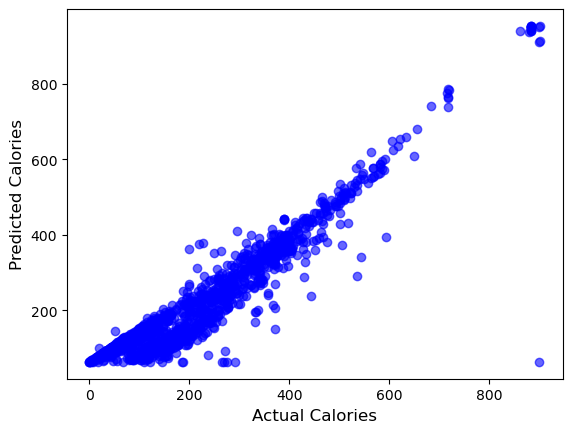

In [8]:
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.xlabel('Actual Calories', fontsize=12)
plt.ylabel('Predicted Calories', fontsize=12)
plt.show()

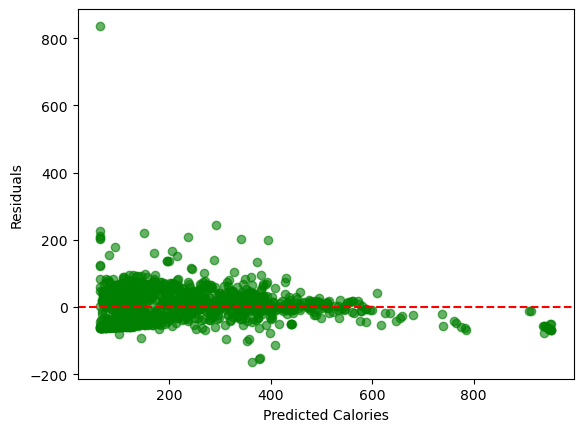

In [9]:
residuals = y_test.values - y_pred
plt.scatter(y_pred, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Calories')
plt.ylabel('Residuals')
plt.show()